In [1]:
import pandas as pd

import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from statsmodels.api import qqplot, add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

from sklearn.linear_model import Ridge, Lasso, ElasticNet

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

import platform
platform.system()

# 운영체제별 한글 폰트 설정
if platform.system() == 'Darwin': # Mac 환경 폰트 설정
    plt.rc('font', family='AppleGothic')
elif platform.system() == 'Windows': # Windows 환경 폰트 설정
    plt.rc('font', family='Malgun Gothic')

plt.rc('axes', unicode_minus=False) # 마이너스 폰트 설정


import warnings
warnings.filterwarnings('ignore')

In [3]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'NanumGothic'

matplotlib.rc("axes", unicode_minus = False)

In [4]:
df = pd.read_csv("SCALE불량.csv", encoding = "euc-kr")
df.head(3)

,plate_no,rolling_date,scale,spec_long,spec_country,steel_kind,pt_thick,pt_width,pt_length,hsb,...,fur_heat_temp,fur_heat_time,fur_soak_temp,fur_soak_time,fur_total_time,fur_ex_temp,rolling_method,rolling_temp,descaling_count,work_group
0,PLT_1001,03JAN2023:07:07:53,양품,AB/EH32-TM,미국,T,32,3700,15100,적용,...,1144,116,1133,59,259,1133,TMCP(온도제어),934,8,1조
1,PLT_1002,03JAN2023:07:21:22,양품,AB/EH32-TM,미국,T,32,3700,15100,적용,...,1144,122,1135,53,238,1135,TMCP(온도제어),937,8,1조
2,PLT_1003,03JAN2023:07:31:15,양품,NV-E36-TM,영국,T,33,3600,19200,적용,...,1129,116,1121,55,258,1121,TMCP(온도제어),889,8,1조


In [5]:
df['hsb'].unique()

array(['적용', '미적용'], dtype=object)

In [6]:
# # 목표변수를 불량을 1로 변환
df['scale']=df['scale'].replace({'양품' : 0, '불량' : 1})

In [7]:
from sklearn.preprocessing import LabelEncoder

# hsb 인코딩
# LabelEncoder 객체 생성
label_encoder = LabelEncoder()

# 'hsb' 열을 숫자로 인코딩
df['hsb'] = label_encoder.fit_transform(df['hsb'])

# 인코딩된 값 확인
encoded_values = df['hsb'].unique()
print(encoded_values)

[1 0]


In [8]:
# hsb 인코딩
# LabelEncoder 객체 생성
label_encoder = LabelEncoder()

# 'hsb' 열을 숫자로 인코딩
df['hsb'] = label_encoder.fit_transform(df['hsb'])

# 인코딩된 값 확인
encoded_values = df['hsb'].unique()
print(encoded_values)

[1 0]


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   plate_no         1000 non-null   object
 1   rolling_date     1000 non-null   object
 2   scale            1000 non-null   int64 
 3   spec_long        1000 non-null   object
 4   spec_country     1000 non-null   object
 5   steel_kind       1000 non-null   object
 6   pt_thick         1000 non-null   int64 
 7   pt_width         1000 non-null   int64 
 8   pt_length        1000 non-null   int64 
 9   hsb              1000 non-null   int64 
 10  fur_no           1000 non-null   object
 11  fur_input_row    1000 non-null   object
 12  fur_heat_temp    1000 non-null   int64 
 13  fur_heat_time    1000 non-null   int64 
 14  fur_soak_temp    1000 non-null   int64 
 15  fur_soak_time    1000 non-null   int64 
 16  fur_total_time   1000 non-null   int64 
 17  fur_ex_temp      1000 non-null   i

In [10]:
df.isnull().sum()

plate_no           0
rolling_date       0
scale              0
spec_long          0
spec_country       0
steel_kind         0
pt_thick           0
pt_width           0
pt_length          0
hsb                0
fur_no             0
fur_input_row      0
fur_heat_temp      0
fur_heat_time      0
fur_soak_temp      0
fur_soak_time      0
fur_total_time     0
fur_ex_temp        0
rolling_method     0
rolling_temp       0
descaling_count    0
work_group         0
dtype: int64

In [11]:
# 가열로 추출온도 겹치는 column이므로 제거
df.drop('fur_ex_temp', axis=1, inplace=True)

In [12]:
# plate 번호는 수율에 영향을 주지 못한다고 판단하여 제거
df.drop('plate_no', axis=1, inplace=True)

#### rolling_date를 문자를 제거한 후 daytime으로 변환하여 날짜까지 나타내는 Datetime과 시간 값을 가진 time으로 나눔

In [13]:
df['datetime'] = pd.to_datetime(df['rolling_date'], format='%d%b%Y:%H:%M:%S', errors='coerce')
df['time'] = df['datetime'].dt.time

In [14]:
df['datetime']

0     2023-01-03 07:07:53
1     2023-01-03 07:21:22
2     2023-01-03 07:31:15
3     2023-01-03 07:41:01
4     2023-01-03 07:52:40
              ...        
995   2023-01-10 05:32:25
996   2023-01-10 05:39:19
997   2023-01-10 05:52:41
998   2023-01-10 06:01:50
999   2023-01-10 06:16:27
Name: datetime, Length: 1000, dtype: datetime64[ns]

In [15]:
df['time']

0      07:07:53
1      07:21:22
2      07:31:15
3      07:41:01
4      07:52:40
         ...   
995    05:32:25
996    05:39:19
997    05:52:41
998    06:01:50
999    06:16:27
Name: time, Length: 1000, dtype: object

In [16]:
# datetime, time 생성 했으므로 기존 시간데이터 제거
df.drop('rolling_date', axis=1, inplace=True)

In [17]:
# 'datetime' 열에서 시간 정보만 추출하여 새로운 열 생성
df['hour'] = df['datetime'].dt.hour

# 각 시간대별로 'encoded_scale'이 1인 행의 비율 계산
percentage_by_hour = df.groupby('hour')['scale'].mean() * 100
# 시간에 따른 수율 확인
print(percentage_by_hour)

hour
0     34.090909
1     28.571429
2     37.209302
3     20.930233
4     26.190476
5     31.111111
6     30.303030
7     32.500000
8     25.000000
9     43.589744
10    42.500000
11    46.666667
12    51.219512
13    37.500000
14    25.581395
15    25.000000
16    34.146341
17    31.111111
18    27.500000
19    16.666667
20    14.634146
21    13.953488
22    29.268293
23    39.534884
Name: scale, dtype: float64


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   scale            1000 non-null   int64         
 1   spec_long        1000 non-null   object        
 2   spec_country     1000 non-null   object        
 3   steel_kind       1000 non-null   object        
 4   pt_thick         1000 non-null   int64         
 5   pt_width         1000 non-null   int64         
 6   pt_length        1000 non-null   int64         
 7   hsb              1000 non-null   int64         
 8   fur_no           1000 non-null   object        
 9   fur_input_row    1000 non-null   object        
 10  fur_heat_temp    1000 non-null   int64         
 11  fur_heat_time    1000 non-null   int64         
 12  fur_soak_temp    1000 non-null   int64         
 13  fur_soak_time    1000 non-null   int64         
 14  fur_total_time   1000 non-null   int64   

#### 파생변수 생성

In [19]:
# 후판 면적 파생변수 생성
df['pt_area'] = df['pt_length'] * df['pt_width']

In [20]:
# 가열대와 균열대 온도차 파생변수 생성
df['fur_temp_gap'] = df['fur_heat_temp'] - df['fur_soak_temp']

#### 이상치 확인

In [21]:
df.describe()

,scale,pt_thick,pt_width,pt_length,hsb,fur_heat_temp,fur_heat_time,fur_soak_temp,fur_soak_time,fur_total_time,rolling_temp,descaling_count,hour,pt_area,fur_temp_gap
count,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1.000000e+03,1000.000000
mean,0.310000,26.78200,2831.900000,36788.200000,0.953000,1157.245000,85.972000,1150.928000,71.720000,238.589000,934.637000,8.557000,11.493000,1.051967e+08,6.317000
std,0.462725,18.13757,494.081478,13912.387116,0.211745,21.245007,26.346297,17.344384,20.602137,38.194828,96.598015,1.604158,6.970979,4.509779e+07,13.116347
min,0.000000,12.00000,1800.000000,7900.000000,0.000000,1103.000000,55.000000,1113.000000,35.000000,165.000000,0.000000,5.000000,0.000000,1.764000e+07,-45.000000
25%,0.000000,15.00000,2500.000000,26650.000000,1.000000,1140.000000,66.000000,1135.750000,57.750000,210.000000,893.750000,8.000000,5.000000,6.912000e+07,-1.000000
50%,0.000000,19.00000,2800.000000,40400.000000,1.000000,1159.000000,75.000000,1156.000000,66.000000,230.000000,948.000000,9.000000,11.500000,1.108100e+08,6.000000
75%,1.000000,34.00000,3100.000000,49100.000000,1.000000,1173.000000,102.250000,1164.000000,81.000000,263.000000,991.000000,10.000000,17.250000,1.424775e+08,13.000000
max,1.000000,100.00000,4600.000000,54900.000000,1.000000,1206.000000,158.000000,1185.000000,145.000000,362.000000,1078.000000,10.000000,23.000000,2.184400e+08,56.000000


In [22]:
df['rolling_temp'].unique()

array([ 934,  937,  889,  885,  873,  874,  878,  870,  881,  869,  820,
       1057,  926,  931,  929,  925,  928,  860,  836,  832,  841,  933,
        930,  936,  838,  837,  862,  861,  856,  863,    0,  864,  845,
        808,  850,  852,  847,  849,  844,  853,  851,  840,  846,  834,
        842,  843,  773,  760,  859,  839,  911,  935,  915,  923,  913,
        977,  985,  955,  950,  952,  956,  920,  959,  918,  944,  976,
       1004,  961,  996,  995,  953,  992,  988,  982,  967,  975, 1008,
       1018, 1006,  999, 1005, 1012, 1002, 1023, 1015, 1021, 1011, 1013,
       1019, 1026, 1027, 1020, 1014, 1022, 1007, 1017, 1031, 1030, 1062,
       1078, 1066, 1056, 1054, 1068, 1053,  902,  907, 1037,  901, 1024,
       1035, 1016, 1029, 1010, 1000,  991,  945,  941,  962,  979,  993,
       1038, 1043, 1046, 1034, 1032,  997,  986,  989, 1048, 1003,  998,
        987,  968,  980,  973,  971,  972,  969,  957,  958,  951,  939,
        947,  970,  983,  984,  899, 1009,  981,  9

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 24 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   scale            1000 non-null   int64         
 1   spec_long        1000 non-null   object        
 2   spec_country     1000 non-null   object        
 3   steel_kind       1000 non-null   object        
 4   pt_thick         1000 non-null   int64         
 5   pt_width         1000 non-null   int64         
 6   pt_length        1000 non-null   int64         
 7   hsb              1000 non-null   int64         
 8   fur_no           1000 non-null   object        
 9   fur_input_row    1000 non-null   object        
 10  fur_heat_temp    1000 non-null   int64         
 11  fur_heat_time    1000 non-null   int64         
 12  fur_soak_temp    1000 non-null   int64         
 13  fur_soak_time    1000 non-null   int64         
 14  fur_total_time   1000 non-null   int64   

#### rolling_temp = 0인 값은 이상치로 판단하여 제거

In [24]:
df = df[df['rolling_temp'] != 0]
df['rolling_temp'].unique()

array([ 934,  937,  889,  885,  873,  874,  878,  870,  881,  869,  820,
       1057,  926,  931,  929,  925,  928,  860,  836,  832,  841,  933,
        930,  936,  838,  837,  862,  861,  856,  863,  864,  845,  808,
        850,  852,  847,  849,  844,  853,  851,  840,  846,  834,  842,
        843,  773,  760,  859,  839,  911,  935,  915,  923,  913,  977,
        985,  955,  950,  952,  956,  920,  959,  918,  944,  976, 1004,
        961,  996,  995,  953,  992,  988,  982,  967,  975, 1008, 1018,
       1006,  999, 1005, 1012, 1002, 1023, 1015, 1021, 1011, 1013, 1019,
       1026, 1027, 1020, 1014, 1022, 1007, 1017, 1031, 1030, 1062, 1078,
       1066, 1056, 1054, 1068, 1053,  902,  907, 1037,  901, 1024, 1035,
       1016, 1029, 1010, 1000,  991,  945,  941,  962,  979,  993, 1038,
       1043, 1046, 1034, 1032,  997,  986,  989, 1048, 1003,  998,  987,
        968,  980,  973,  971,  972,  969,  957,  958,  951,  939,  947,
        970,  983,  984,  899, 1009,  981,  960,  9

In [25]:
# hour와 겹침, 제거
df.drop('time', axis=1, inplace=True)

In [26]:
# spec_long 제거, 데이터 부족 유의미한 분석 어려움
df.drop('spec_long', axis=1, inplace=True)

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 994 entries, 0 to 999
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   scale            994 non-null    int64         
 1   spec_country     994 non-null    object        
 2   steel_kind       994 non-null    object        
 3   pt_thick         994 non-null    int64         
 4   pt_width         994 non-null    int64         
 5   pt_length        994 non-null    int64         
 6   hsb              994 non-null    int64         
 7   fur_no           994 non-null    object        
 8   fur_input_row    994 non-null    object        
 9   fur_heat_temp    994 non-null    int64         
 10  fur_heat_time    994 non-null    int64         
 11  fur_soak_temp    994 non-null    int64         
 12  fur_soak_time    994 non-null    int64         
 13  fur_total_time   994 non-null    int64         
 14  rolling_method   994 non-null    object   

In [28]:
df.columns

Index(['scale', 'spec_country', 'steel_kind', 'pt_thick', 'pt_width',
       'pt_length', 'hsb', 'fur_no', 'fur_input_row', 'fur_heat_temp',
       'fur_heat_time', 'fur_soak_temp', 'fur_soak_time', 'fur_total_time',
       'rolling_method', 'rolling_temp', 'descaling_count', 'work_group',
       'datetime', 'hour', 'pt_area', 'fur_temp_gap'],
      dtype='object')

In [29]:
df.head()

,scale,spec_country,steel_kind,pt_thick,pt_width,pt_length,hsb,fur_no,fur_input_row,fur_heat_temp,...,fur_soak_time,fur_total_time,rolling_method,rolling_temp,descaling_count,work_group,datetime,hour,pt_area,fur_temp_gap
0,0,미국,T,32,3700,15100,1,1호기,1열,1144,...,59,259,TMCP(온도제어),934,8,1조,2023-01-03 07:07:53,7,55870000,11
1,0,미국,T,32,3700,15100,1,1호기,2열,1144,...,53,238,TMCP(온도제어),937,8,1조,2023-01-03 07:21:22,7,55870000,9
2,0,영국,T,33,3600,19200,1,2호기,1열,1129,...,55,258,TMCP(온도제어),889,8,1조,2023-01-03 07:31:15,7,69120000,8
3,0,영국,T,33,3600,19200,1,2호기,2열,1152,...,68,266,TMCP(온도제어),885,8,1조,2023-01-03 07:41:01,7,69120000,25
4,0,프랑스,T,38,3100,13300,1,3호기,1열,1140,...,48,246,TMCP(온도제어),873,8,1조,2023-01-03 07:52:40,7,41230000,12


In [30]:
import matplotlib.pyplot as plt
import seaborn as sns


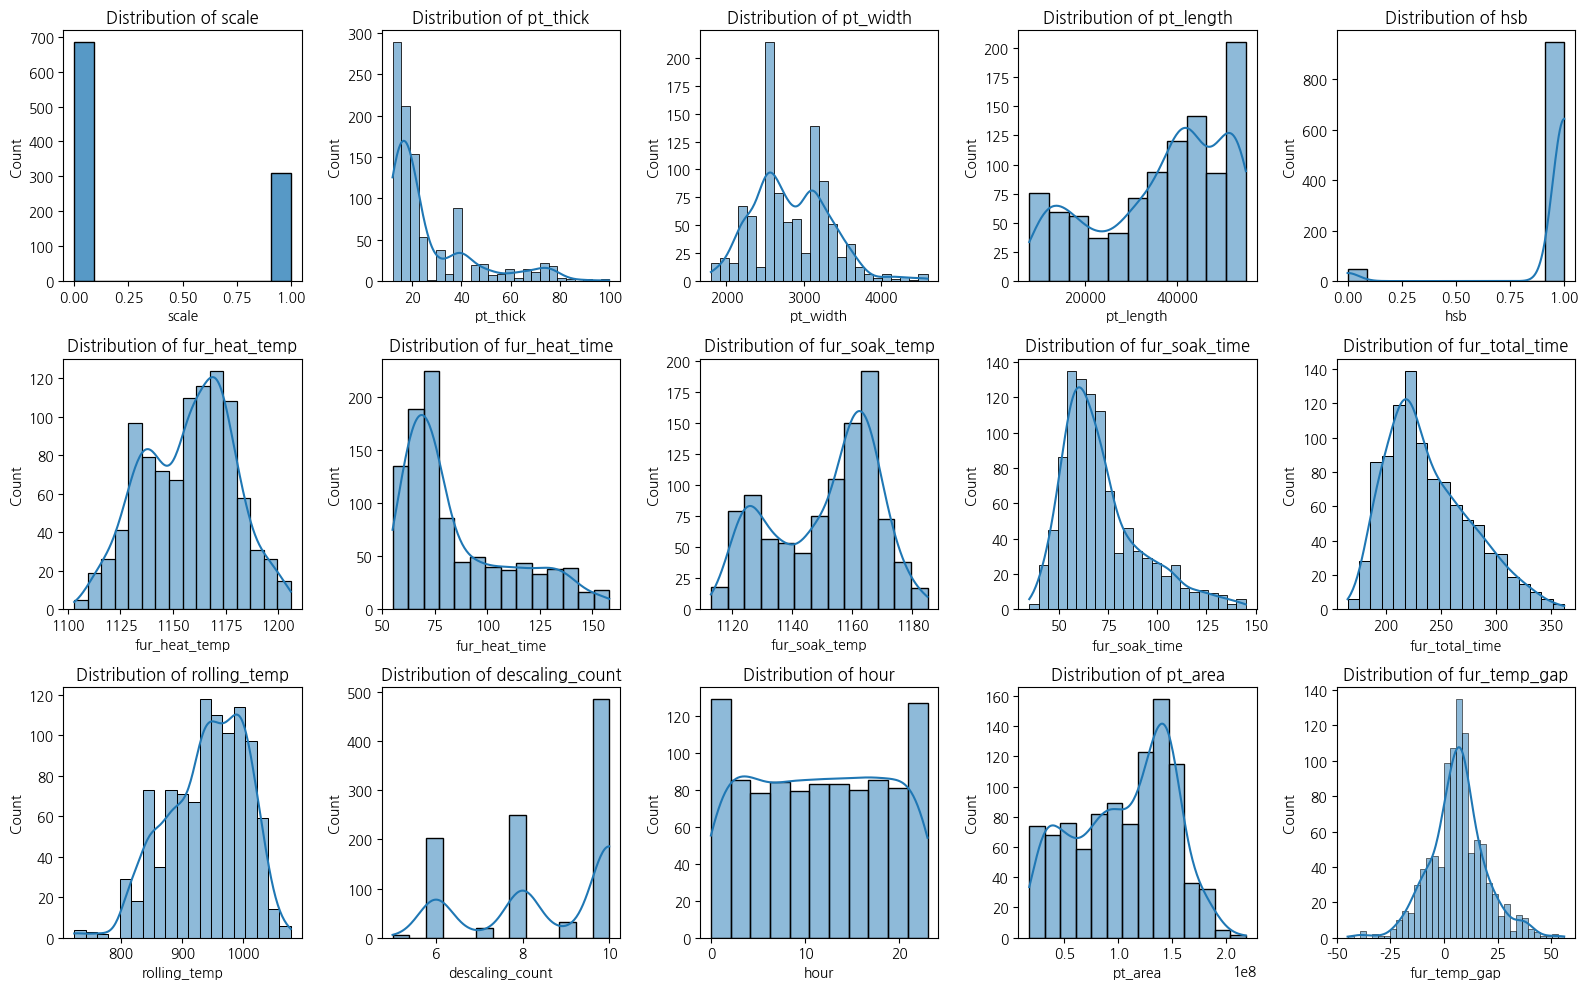

In [31]:
# 그래프의 전체 크기 설정
plt.figure(figsize=(16, 10))

# 히스토그램 그리기
plt.subplot(3, 5, 1)
sns.histplot(df['scale'])
plt.title('Distribution of scale')

plt.subplot(3, 5, 2)
sns.histplot(df['pt_thick'], kde=True)
plt.title('Distribution of pt_thick')

plt.subplot(3, 5, 3)
sns.histplot(df['pt_width'], kde=True)
plt.title('Distribution of pt_width')

plt.subplot(3, 5, 4)
sns.histplot(df['pt_length'], kde=True)
plt.title('Distribution of pt_length')

plt.subplot(3, 5, 5)
sns.histplot(df['hsb'], kde=True)
plt.title('Distribution of hsb')

plt.subplot(3, 5, 6)
sns.histplot(df['fur_heat_temp'], kde=True)
plt.title('Distribution of fur_heat_temp')

plt.subplot(3, 5, 7)
sns.histplot(df['fur_heat_time'], kde=True)
plt.title('Distribution of fur_heat_time')

plt.subplot(3, 5, 8)
sns.histplot(df['fur_soak_temp'], kde=True)
plt.title('Distribution of fur_soak_temp')

plt.subplot(3, 5, 9)
sns.histplot(df['fur_soak_time'], kde=True)
plt.title('Distribution of fur_soak_time')

plt.subplot(3, 5, 10)
sns.histplot(df['fur_total_time'], kde=True)
plt.title('Distribution of fur_total_time')

plt.subplot(3, 5, 11)
sns.histplot(df['rolling_temp'], kde=True)
plt.title('Distribution of rolling_temp')

plt.subplot(3, 5, 12)
sns.histplot(df['descaling_count'], kde=True)
plt.title('Distribution of descaling_count')

plt.subplot(3, 5, 13)
sns.histplot(df['hour'], kde=True)
plt.title('Distribution of hour')

plt.subplot(3, 5, 14)
sns.histplot(df['pt_area'], kde=True)
plt.title('Distribution of pt_area')

plt.subplot(3, 5, 15)
sns.histplot(df['fur_temp_gap'], kde=True)
plt.title('Distribution of fur_temp_gap')

plt.tight_layout()
plt.show()


## 목포변수 범주형 scale


### 설명변수 범주형  spec_country,steel_kind 

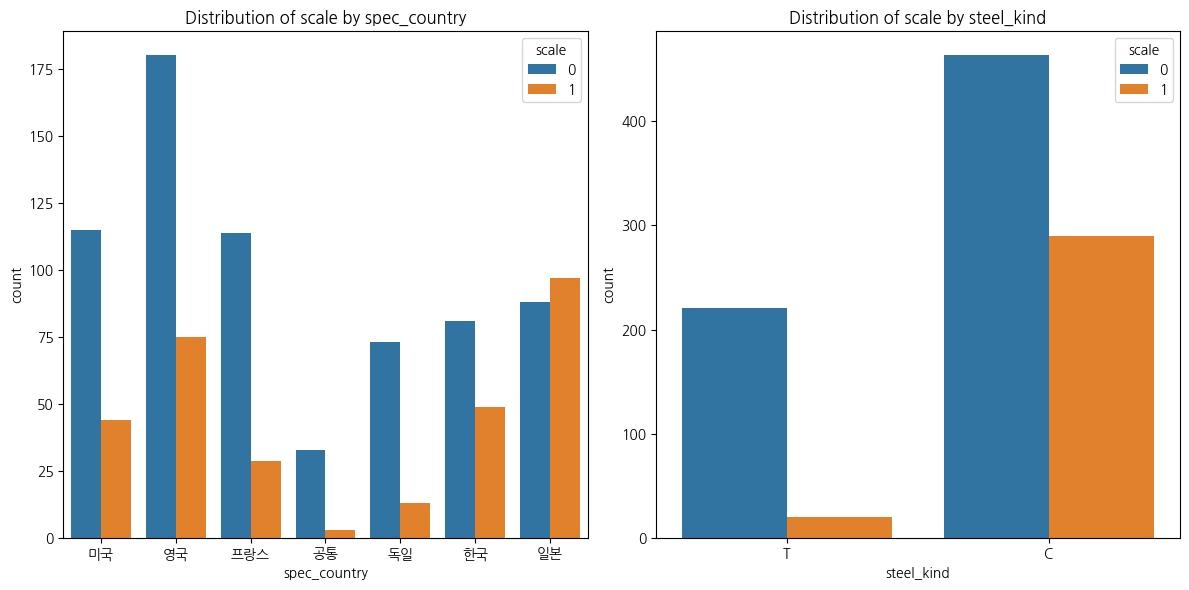

In [32]:
# 그래프의 전체 크기 설정
plt.figure(figsize=(12, 6))

# spec_country에 따른 scale의 분포 시각화
plt.subplot(1, 2, 1)
sns.countplot(x='spec_country', hue='scale', data=df)
plt.title('Distribution of scale by spec_country')

# steel_kind에 따른 scale의 분포 시각화
plt.subplot(1, 2, 2)
sns.countplot(x='steel_kind', hue='scale', data=df)
plt.title('Distribution of scale by steel_kind')

plt.tight_layout()
plt.show()


### 설명변수 연속형  pt_thick,pt_width,pt_length

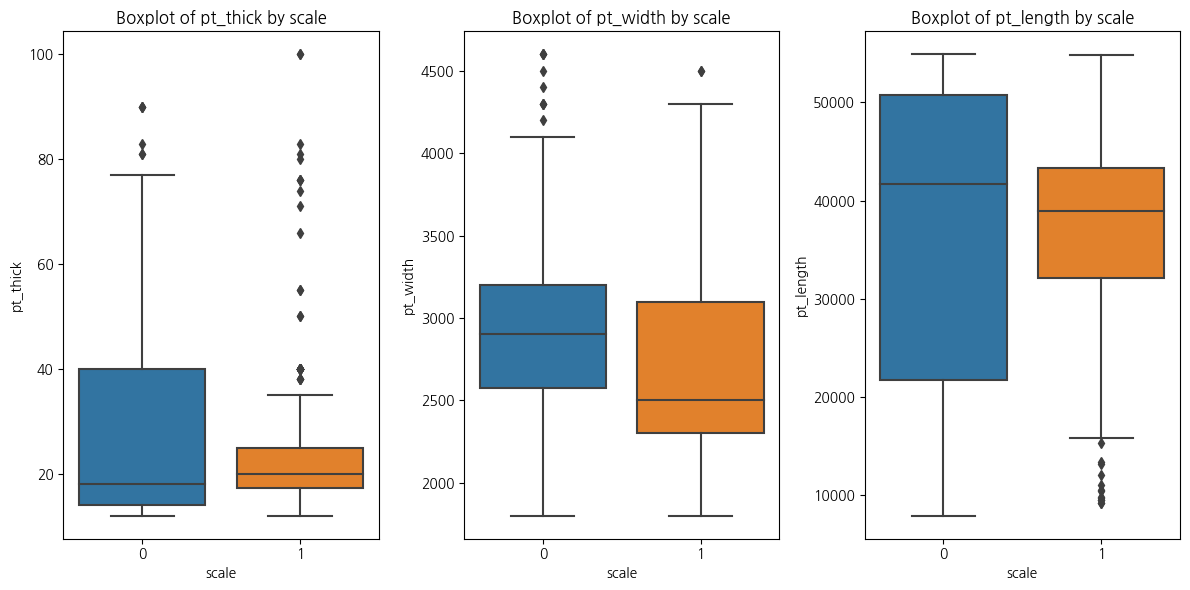

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

# 박스 플롯 그리기
plt.figure(figsize=(12, 6))

# pt_thick에 따른 scale의 분포
plt.subplot(1, 3, 1)
sns.boxplot(x='scale', y='pt_thick', data=df)
plt.xlabel('scale')
plt.ylabel('pt_thick')
plt.title('Boxplot of pt_thick by scale')

# pt_width에 따른 scale의 분포
plt.subplot(1, 3, 2)
sns.boxplot(x='scale', y='pt_width', data=df)
plt.xlabel('scale')
plt.ylabel('pt_width')
plt.title('Boxplot of pt_width by scale')

# pt_length에 따른 scale의 분포
plt.subplot(1, 3, 3)
sns.boxplot(x='scale', y='pt_length', data=df)
plt.xlabel('scale')
plt.ylabel('pt_length')
plt.title('Boxplot of pt_length by scale')

plt.tight_layout()
plt.show()

### 설명변수 연속형 hsb(무슨그래프 쓸지 잘모르겠음)

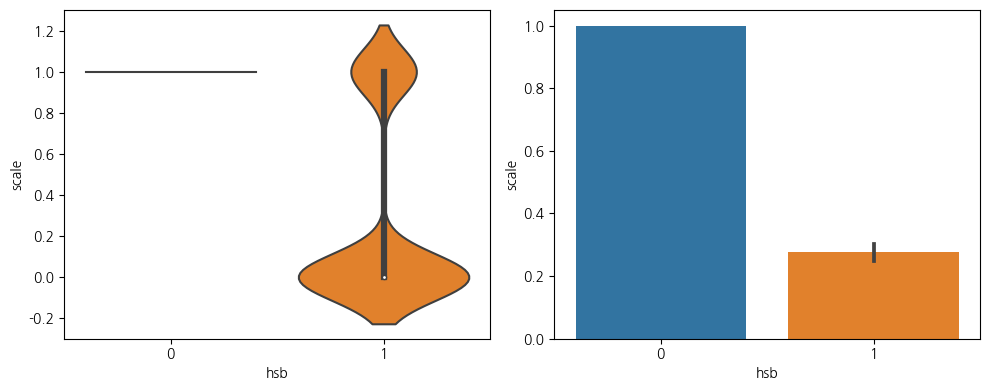

In [34]:
plt.figure(figsize=(10, 4))

plt.subplot(1,2,1)
sns.violinplot(x="hsb", y="scale", data= df)

plt.subplot(1,2,2)
sns.barplot(x="hsb", y="scale", data= df)

plt.tight_layout()
plt.show()

### 설명변수 범주형 fur_no,fur_input_row

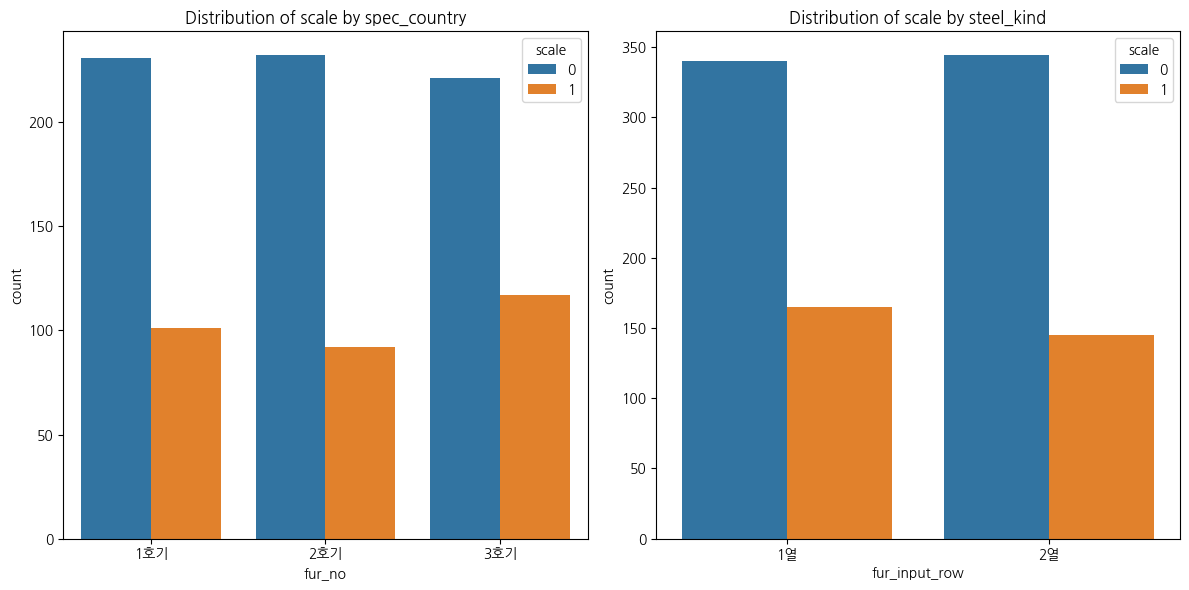

In [35]:
# 그래프의 전체 크기 설정
plt.figure(figsize=(12, 6))

# spec_country에 따른 scale의 분포 시각화
plt.subplot(1, 2, 1)
sns.countplot(x='fur_no', hue='scale', data=df)
plt.title('Distribution of scale by spec_country')

# steel_kind에 따른 scale의 분포 시각화
plt.subplot(1, 2, 2)
sns.countplot(x='fur_input_row', hue='scale', data=df)
plt.title('Distribution of scale by steel_kind')

plt.tight_layout()
plt.show()


### 설명변수 연속형 fur_heat_temp,fur_heat_time,fur_soak_temp,fur_soak_time,fur_total_time

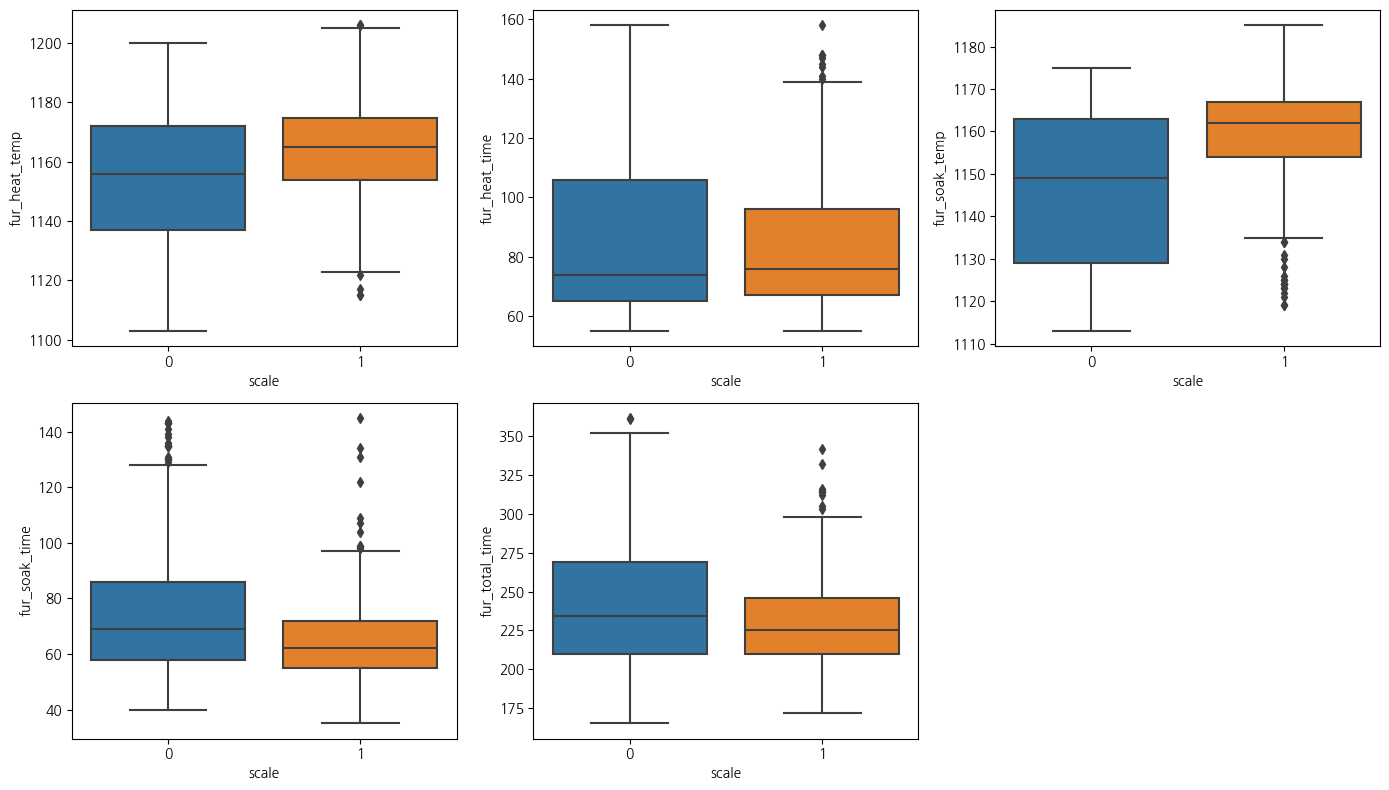

In [36]:
# 각 설명 변수와 목표 변수 간의 관계를 boxplot으로 시각화
plt.figure(figsize=(14, 8))

plt.subplot(2, 3, 1)
sns.boxplot(x='scale', y='fur_heat_temp', data=df)

plt.subplot(2, 3, 2)
sns.boxplot(x='scale', y='fur_heat_time', data=df)

plt.subplot(2, 3, 3)
sns.boxplot(x='scale', y='fur_soak_temp', data=df)

plt.subplot(2, 3, 4)
sns.boxplot(x='scale', y='fur_soak_time', data=df)

plt.subplot(2, 3, 5)
sns.boxplot(x='scale', y='fur_total_time', data=df)

plt.tight_layout()
plt.show()

### 설명변수 범주형 rolling_method,work_group

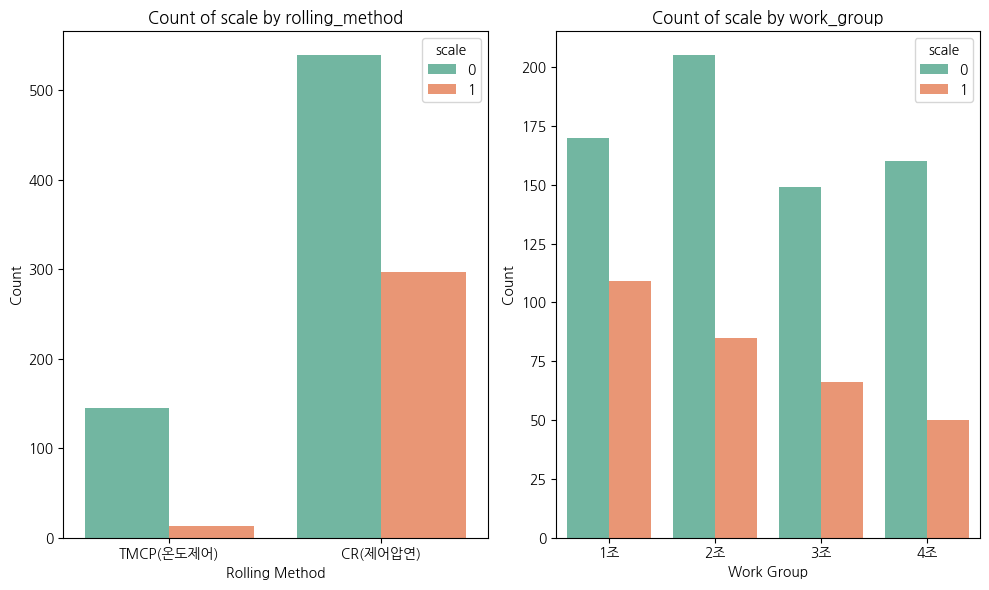

In [37]:
# 범주형 설명 변수와 목표 변수 간의 관계 시각화
plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
sns.countplot(x='rolling_method', hue='scale', data=df, palette='Set2')
plt.title('Count of scale by rolling_method')
plt.xlabel('Rolling Method')
plt.ylabel('Count')
plt.legend(title='scale')

plt.subplot(1, 2, 2)
sns.countplot(x='work_group', hue='scale', data=df, palette='Set2')
plt.title('Count of scale by work_group')
plt.xlabel('Work Group')
plt.ylabel('Count')
plt.legend(title='scale')

plt.tight_layout()
plt.show()

### 설명변수 연속형  rolling_temp,descaling_count

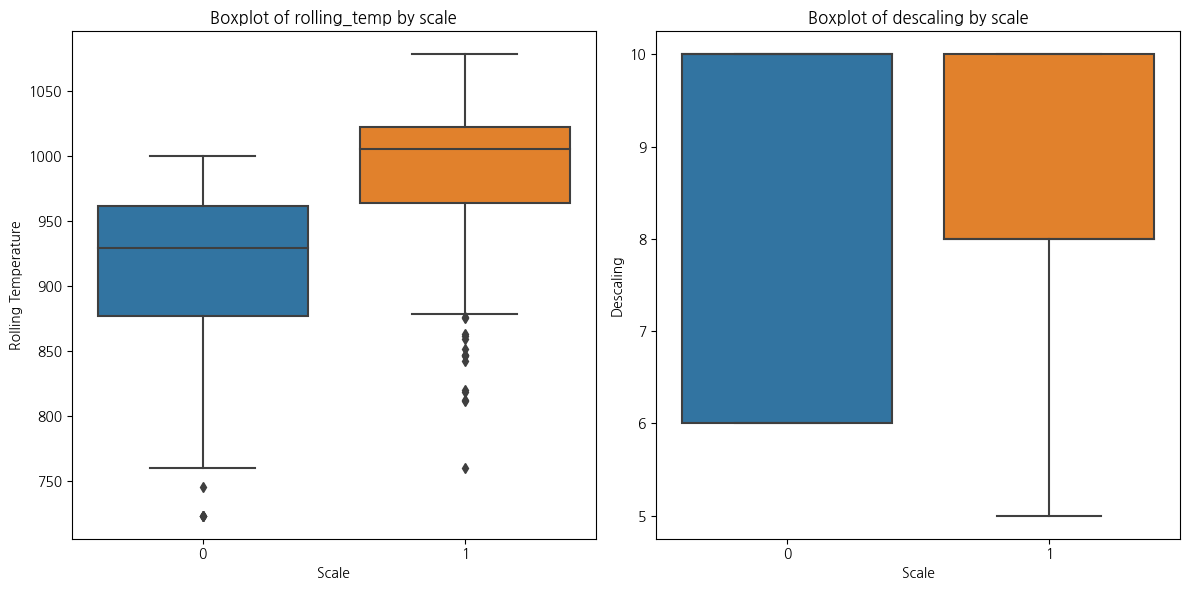

In [38]:

# 연속형 설명 변수와 목표 변수 간의 관계 시각화 (Boxplot)
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.boxplot(x='scale', y='rolling_temp', data=df)
plt.title('Boxplot of rolling_temp by scale')
plt.xlabel('Scale')
plt.ylabel('Rolling Temperature')

plt.subplot(1, 2, 2)
sns.boxplot(x='scale', y='descaling_count', data=df)
plt.title('Boxplot of descaling by scale')
plt.xlabel('Scale')
plt.ylabel('Descaling')

plt.tight_layout()
plt.show()

### 설명변수 연속형  hour,pt_area,fur_temp_gap

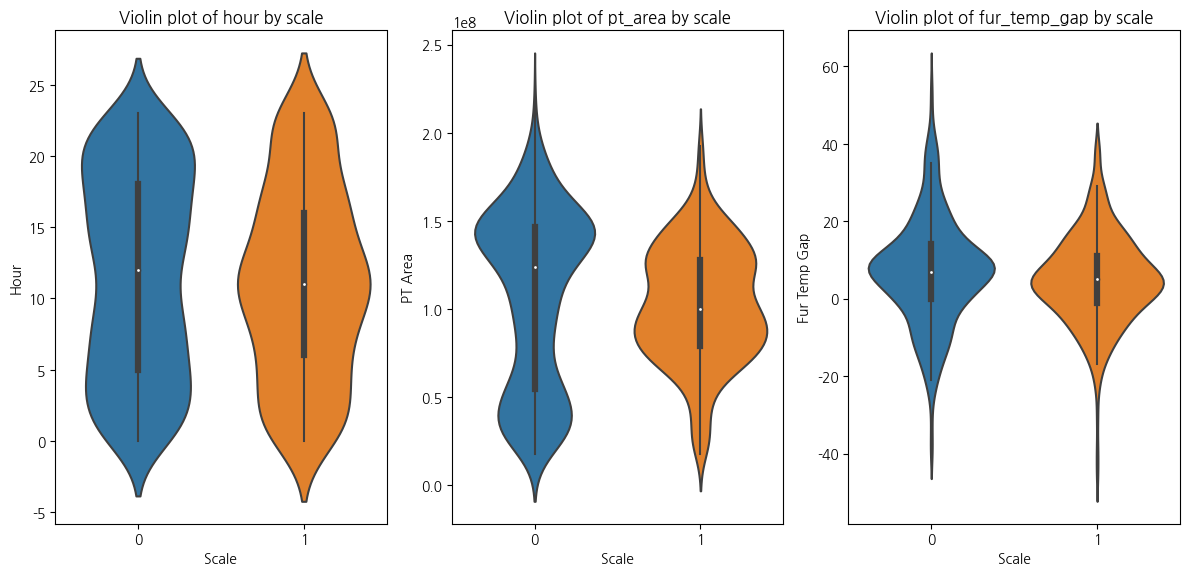

In [39]:
# 연속형 설명 변수와 목표 변수 간의 관계 시각화 (Violin plot)
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
sns.violinplot(x='scale', y='hour', data=df)
plt.title('Violin plot of hour by scale')
plt.xlabel('Scale')
plt.ylabel('Hour')

plt.subplot(1, 3, 2)
sns.violinplot(x='scale', y='pt_area', data=df)
plt.title('Violin plot of pt_area by scale')
plt.xlabel('Scale')
plt.ylabel('PT Area')

plt.subplot(1, 3, 3)
sns.violinplot(x='scale', y='fur_temp_gap', data=df)
plt.title('Violin plot of fur_temp_gap by scale')
plt.xlabel('Scale')
plt.ylabel('Fur Temp Gap')

plt.tight_layout()
plt.show()

### 설명변수 datetime64형식 datetime(날짜에 따른 불량의 개수와 양품의 개수 line plot)

#### 날짜에 따른 불량의 개수

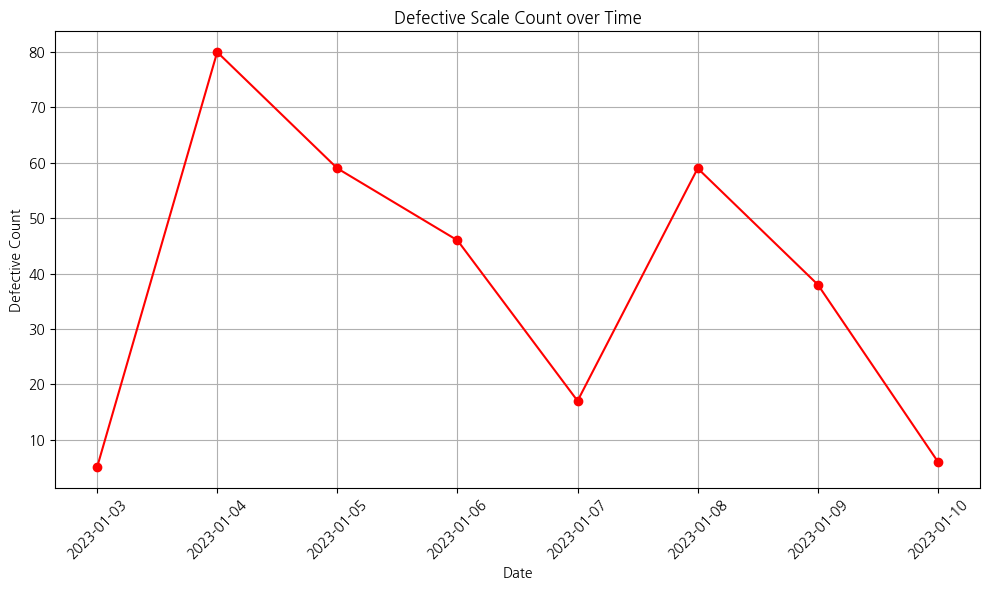

In [52]:
# datetime 열에서 날짜만 추출하여 새로운 열에 저장
df['date'] = df['datetime'].dt.date

# 'scale'이 불량인 경우의 개수 계산
def count_defective(df):
    defective_counts = df[df['scale'] == 1].groupby('date').size()
    return defective_counts.reindex(df['date'].unique(), fill_value=0)

# 선 그래프로 시각화
plt.figure(figsize=(10, 6))

# 'scale'이 불량인 경우의 개수 선 그래프
plt.plot(df['date'].unique(), count_defective(df), marker='o', color='red')

plt.xlabel('Date')
plt.ylabel('Defective Count')
plt.title('Defective Scale Count over Time')
plt.grid(True)
plt.xticks(rotation=45)  # x축 라벨 회전
plt.tight_layout()
plt.show()

#### 날짜에 따른 양품의 개수

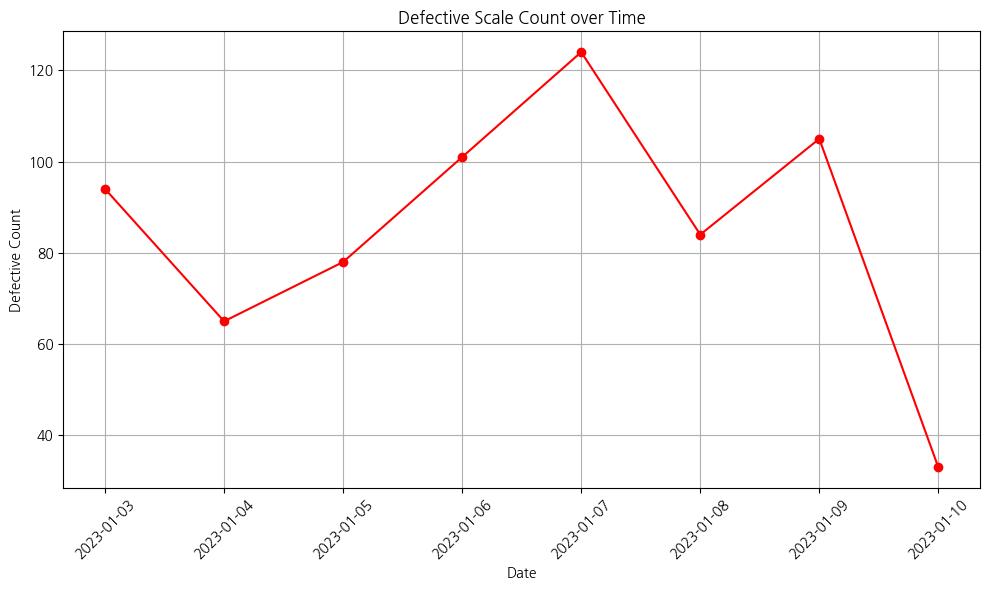

In [53]:
# datetime 열에서 날짜만 추출하여 새로운 열에 저장
df['date'] = df['datetime'].dt.date

# 'scale'이 불량인 경우의 개수 계산
def count_defective(df):
    defective_counts = df[df['scale'] == 0].groupby('date').size()
    return defective_counts.reindex(df['date'].unique(), fill_value=0)

# 선 그래프로 시각화
plt.figure(figsize=(10, 6))

# 'scale'이 불량인 경우의 개수 선 그래프
plt.plot(df['date'].unique(), count_defective(df), marker='o', color='red')

plt.xlabel('Date')
plt.ylabel('Defective Count')
plt.title('Defective Scale Count over Time')
plt.grid(True)
plt.xticks(rotation=45)  # x축 라벨 회전
plt.tight_layout()
plt.show()

#### 날짜에 따라서 불량 개수를 전체 제품 개수에 대한 비율로 나타낸 그래프

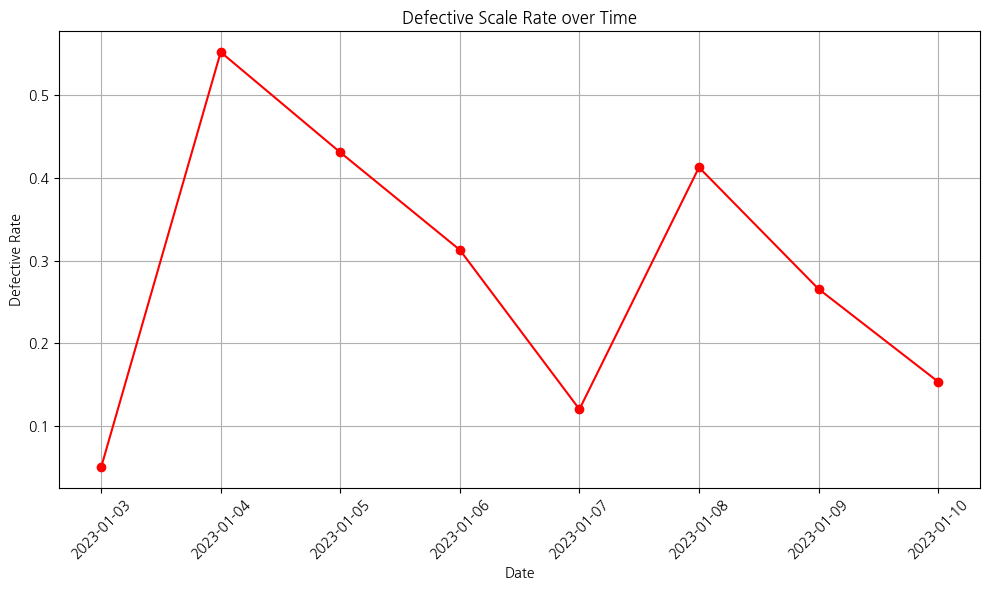

In [55]:
# datetime 열에서 날짜만 추출하여 새로운 열에 저장
df['date'] = df['datetime'].dt.date

# 날짜별 전체 제품 개수 계산
total_counts = df.groupby('date').size()

# 'scale'이 불량인 경우의 개수 계산
def count_defective(df):
    defective_counts = df[df['scale'] == 1].groupby('date').size()
    return defective_counts / total_counts

# 선 그래프로 시각화
plt.figure(figsize=(10, 6))

# 'scale'이 불량인 경우의 비율 선 그래프
plt.plot(df['date'].unique(), count_defective(df), marker='o', color='red')

plt.xlabel('Date')
plt.ylabel('Defective Rate')
plt.title('Defective Scale Rate over Time')
plt.grid(True)
plt.xticks(rotation=45)  # x축 라벨 회전
plt.tight_layout()
plt.show()

### 조에 따라서 날짜에 따른 불량품 빈도

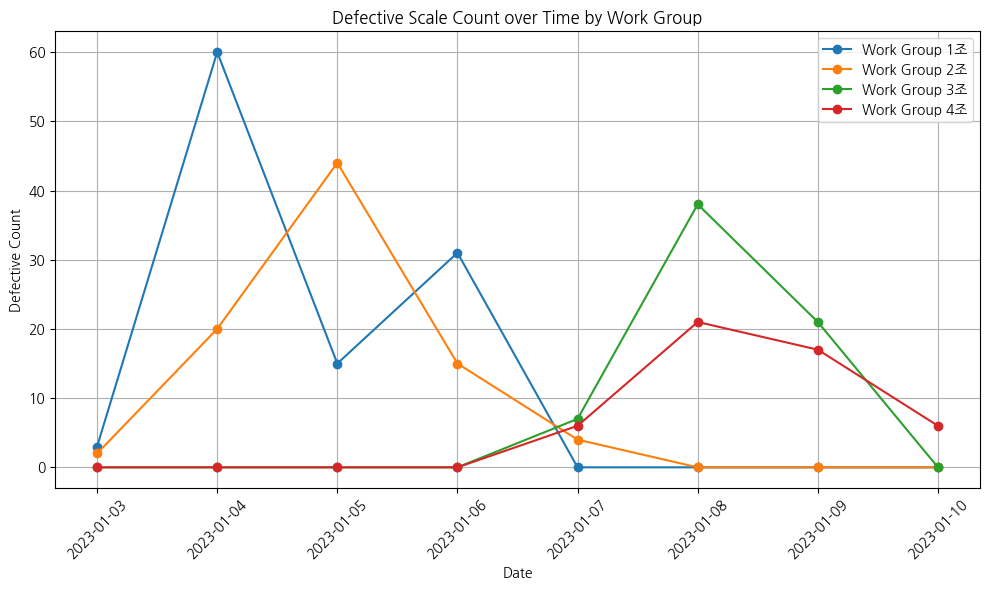

In [54]:
# datetime 열에서 날짜만 추출하여 새로운 열에 저장
df['date'] = df['datetime'].dt.date

# 'work_group' 작업조에 따른 날짜별 불량의 개수 계산
def count_defective_by_work_group(df, work_group):
    defective_counts = df[df['work_group'] == work_group]
    defective_counts = defective_counts[defective_counts['scale'] == 1].groupby('date').size()
    return defective_counts.reindex(df['date'].unique(), fill_value=0)

# 선 그래프로 시각화
plt.figure(figsize=(10, 6))

# 작업조별로 'scale'이 불량인 경우의 개수 선 그래프
for work_group in df['work_group'].unique():
    plt.plot(df['date'].unique(), count_defective_by_work_group(df, work_group), marker='o', label=f'Work Group {work_group}')

plt.xlabel('Date')
plt.ylabel('Defective Count')
plt.title('Defective Scale Count over Time by Work Group')
plt.grid(True)
plt.xticks(rotation=45)  # x축 라벨 회전
plt.legend()
plt.tight_layout()
plt.show()
